#Final Project

## Introduction

#### Goal

I will explore whether a network-theory driven approach shown to improve the efficiency of an agricultural extension program is sensitive to the models and parameters originally used.

#### Justification

Social networks have been shown to be important vehicles for the transmission of new agricultural methods or 'technologies' (Bandiera and Rasul 2006, Conley and Udry 2010).  These types of dynamics and time-varying agent behavior are best captured with through network modeling.

My project is based off a recent paper which used network modeling in conjunction with a large-scale field experiment (Beaman et al 2014).  I wish to test the robustness of the findings of their model and so will employ a similar network modeling method.

#### Background on original paper

Beaman and co-authors aimed to improve the rollout of an agricultural extension program using predictions from network theory to optimally select 'seed farmers'.  'Seed farmers' are the select farmers in a village that the agricultural extension program trains.  Because it is costly to train farmers in this way, it is most efficient to pick seed farmers such that their adoption of the agricultural technology will lead to the greatest spread of the technology throughout the village.  

Beaman and coauthors first elicit the social networks of various rural villages.  Then under the condition that the extension program only trains two farmers in each village, they take every possible combination of two nodes in a village network and simulate an information diffusion process for 4 periods, corresponding to the 4 following agricultural seasons during which they will return and collect data.  They take a measure of information diffusion at the end of the 4 periods and the pair of nodes which gives the greatest diffusion is their optimal seeding pair.  

Their findings are then used in a field experiment where a random half of total villages are seeded according to their simulated optimal seeds while the other half is seeded according to the extension program's default procedure, usually based off of a field officer's own knowledge of the village and its influential farmers.  They find evidence that network-theory informed seeding leads to increased technological adoption over baseline seeding procedures. 

#### My extension and question of interest

I wish to recreate and expand upon their simulations by adding a stochastic, 'persuasion' parameter.  The original information diffusion process used assumes that a household will automatically adopt a technology after the number of connections who have adopted the technology passes a certain threshold.  The persuasion parameter will be value between 0 and 1 and represents the probability that a household, after being exposed to the technology by an adequate number of connections, will actually adopt the technology themselves.  We can think of this as the probabily that a household is convinced to adopt the technology after being exposed to it.  

There is evidence that the diffusion of technology is highly path dependent and sensitive to idiosynchratic shocks (Arthur 1989).  My persuasion parameter is meant to model these types of shocks.  A change in agricultural technology would have been a major, costly decision for these rural households so it is reasonable to guess that not all households would adopt a new technology, even after seeing others use it. 

I want to know whether this type of path dependence has an effect on the choice of Beaman et al's 'optimal seeding pair'.  If it does, and an information diffusion process with this type of path dependence is more reflective of reality, there is room for Beaman et al's method to be improved and become more useful in the field.


## Methods

#### Network data

The original paper looks at rural villages in Malawi.  I do not have access to their network data but I do have a dataset of social graphs from 74 villages in South India.  Though there may be differences in network structure between villages in these two locations, I will assume they are reasonably comparable.

Due to computational limits, I will run analysis only on the social graph of a single village.  This village was chosen because it has the smallest number of nodes among all villages I have data for and was therefore the fastest to run simulations on.  This reduces the generalizability of my results but still provides a useful starting point for analysis.

#### Information diffusion process

First, I will select all combinations of node pairs in the chosen village.  For each pair, I will simulate an information diffusion simulation for 4 steps and record the percent of households adopted at last step.  This information diffusion simulation is repeated 20 times and then I average this measure of information diffusion across the 20 repetitions.  The pair of nodes which give the greatest average information difussion is the theory-driven, optimal seeding pair like those found in Beaman et al.  The optimal seeding pair can be identified through data manipulation after outputting simulation data to a pandas dataframe.  I will examine whether the determination of these optimal seed farmers depends on the parameters described below.

Each household has an adoption threshold, $\tau$, which determines whether they are 'exposed' to the new technology or not.  If $x$ number of connections have adopted the technology and $ x \geq \tau$, then the household is considered exposed to the new technology.  Each household independently drawns a threshold from a normal distribution $N(\alpha, 0.5)$ bounded positive.

I will vary this $\alpha$ parameter between 1 and 2 as in the original paper.  Pushing up and down this parameter corresponds to 'simple contagion' and 'complex contagion' models of diffusion.  Simple contagion requires that, for an individual to be exposed to the technology, only one connection needs to have adopted the technology.  Complex contagion requires that the individual be connected to two or more households who have adopted the technology.  

In each step, after meeting the exposure criterion, a household will draw a number from the uniform distribution $[0,1)$.  If the random number is less than or equal to the global persuasion parameter, $\rho$, the household will adopt the technology in the next period.  I will sweep through $\rho$ equal to 0.5, 0.75 and 1.  Persuasion equal to 1 corresponds to the original model in Beaman et al where a household automatically adopts the technology after an adequate number of connections has also adopted the technology.  I want to see whether the seed households selected when $\rho = 1$ are the same or similar to those selected when $\rho \neq 1$.

I am also interested in how $\alpha$ will interact with the 'persuasion' parameter I am introducing.  With a distribution of more $\alpha \geq 2$, we might expect seeds closer to each other to be more effective at speading technology.  Under the condition where persuasion is harder to achieve though, we may instead want seed households to be farther apart in the network, to hedge against the risk of non-persuasion.  I am not measuring degree of distance between seed households here but we should get an idea of this effect by looking for a change in optimal seed pairing as the persuasion parameter gets lower.

#### Comparing optimal seeds

At a basic level, I can see whether optimal seeding pair changes across parameter values just by observing the optimal nodes at each combination of parameter values.  To take this analysis deeper, I will compute a centrality measure for optimal nodes.  So, if I find that optimal nodes differ under different parameters, I will also be able to observe whether these nodes are similar in centrality or not.  Beaman et al find that eigenvector centrality is a good predictor of optimal seeds in their dataset, so I will use this centrality measure.


##Code

####Imports

In [7]:
#Imports

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx
import pandas
import seaborn; seaborn.set()
import scipy.stats as stats

# Import widget methods
from IPython.html.widgets import *

### Sweep parameters
I will sweep through the following parameters:

- alpha will take on values 1 and 2
- persuasion will take on values 0.5, 0.75 and 1

Varying alpha between 1 and 2 will implement models of both simple contagion and complex contagion.  Persuasion at 1 will be equivalent to the adoption after adequate exposure model in Beaman et al.  Bringing persuasion down to 0.5 and 0.75 will introduce the chance of idiosyncratic non-adoption.  

These parameter sweeps will affect the percent adoption measure I take at the end of the 4 model steps.  This is turn, will affect the optimal seeding pair (defined as the pair giving the highest percent adoption).  I can then examine the nodes in these optimal seeding pairs as well as the centrality of each of these nodes to examine the effect of the persuasion parameters, both its independent effect and the effect through its interaction with alpha


### Outline of Code

####I. Space
I will model space with an undirected social network.  Each node represents a rural household and each edge represents a social connection.

####II. Actors
Each node in my network is a household.  They are modeled simply and have only a few properties:
- id: household id
- adopted: whether they have adopted the new technology or not
- threshold: the threshold above which they are considered exposed to the technology.  This threshold will be drawn from a normal distribution with mean $\alpha$ and standard deviation 0.5 which is bounded to be positive.

In a step, each unadopted household will count the number of connections who have adopted the new technology.  If this count exceeds a household's adoption threshold, it has been exposed to the new technology and will, with a probability determined by the persuasion parameter, adopt the new technology.


####III. Model Wrapper

I will wrap my model in code which takes the social graph of a given village and loops through every possible pair of nodes.  Then, I will sweep through my parameters, alpha and persuasion.


####V. Model Parameters
My model will have the following parameters:
- network: adjacency matrix that is read in from wrapper
- alpha: parameter determining distribution of adoption threshold
- seeds: seed nodes
- persuasion: the global persuasion parameter


###Household class
The household class consists of:
- constructor: class constructor, which "initializes" or "creates" the household when we call Household(). This is in the __init__ method.
- adopt_decision: function to model a household's per-step technology adoption decision

In [ ]:
class Household(object):
    """
    Household class, which encapsulates the entire behavior of a household.
    """
    
    def __init__(self, model, household_id, adopted=False, threshold=1):
        """
        Constructor for HH class.  By default,
          * not adopted
          * threshold = 1
          
        Must "link" the Household to their "parent" Model object.
        """
        # Set model link and ID
        self.model = model
        self.household_id = household_id
        
        # Set HH parameters.
        self.adopted = adopted
        self.threshold = threshold
        
    def adopt_decision(self):
        """
        Model a household evaluating their connections and making an adopt/not adopt decision
        """

        adopt_count = 0  ## Count adopted neighbors
        list = self.model.get_neighborhood(self.model.network,self.household_id) ## List of neighboring nodes
        for j in list:
            for h in self.model.HH_adopted:
                if j == h.household_id: ## If neighbor has adopted technology
                    adopt_count+=1

        if adopt_count >= self.threshold: ## Check against HH adoption threshold
            if np.random.random() <= self.model.persuasion: ## Check against stochastic persuasion parameter
                self.adopted = True
 

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

###Model class

Below, we will define our model class. This can be broken up as follows:
- constructor: class constructor, which "initializes" or "creates" the model when we call Model(). This is in the __init__ method.
- setup_households: sets up households, seed and non-seed households are initialized into different lists
- get_neighborhood: defines a function to get a list of connected nodes
- step_adopt_decision: method to step through adoption decision for all unadopted households
- step: main step method

In [ ]:
class Model(object):
    """
    Model class, which encapsulates the entire behavior of a single "run" in network model.
    """
    
    def __init__(self, network, alpha, seeds, persuasion):
        """
        Class constructor.
        """
        # Set our model parameters
        self.network = network
        self.alpha =  alpha
        self.seeds = seeds
        self.persuasion = persuasion
       
        # Set our state variables
        self.t = 0
        self.HH_adopted = []
        self.HH_not_adopted = []
        self.num_households = len(nx.nodes(network))
        self.percent_adopted = 0
        
        # Setup our history variables.
        self.history_adopted = []
        self.history_not_adopted = []
        self.history_percent_adopted = []
        
        # Call our setup methods
        self.setup_households()

        
    def setup_households(self):
        """
        Method to setup households.
        """
        # Create all households.
        # Initialize seeds and non-seeds separately
        
        # Non-seeds
        unadopt_start = [x for x in xrange(self.num_households) if x not in self.seeds]  ## List of HH minus seeds
        for i in unadopt_start:
            self.HH_not_adopted.append(Household(model=self,
                                      household_id=i,
                                      adopted=False,
                                      threshold=stats.truncnorm.rvs((0 - self.alpha) / 0.5, (self.alpha) / 0.5, loc=self.alpha, scale=0.5,size=1)))   
        # Seeds
        for i in self.seeds:
            self.HH_adopted.append(Household(model=self,
                                      household_id=i,
                                      adopted=True,
                                      threshold=stats.truncnorm.rvs((0 - self.alpha) / 0.5, (self.alpha) / 0.5, loc=self.alpha, scale=0.5,size=1))) 
                                             
    def get_neighborhood(self, network, household_id):
        """
        Get a list of connected nodes.
        """
        neighbors = []
        for i in nx.neighbors(network,household_id):
            neighbors.append(i)
        return neighbors 
    
    
    
    def step_adopt_decision(self):
        
        """
        Run adoption decision for all households
        """
        
        # List of all HH's that will adopt in next step
        will_adopt = []
        
        for i in self.HH_not_adopted:
            
            # Run adoption decision household-by-household
            i.adopt_decision()
            
            # If HH has adopted, add to will adopt list
            if i.adopted:
                will_adopt.append(i)
       
        return will_adopt
    
    def step(self):
        """
        Model step function.
        """
        
        # Increment steps and track history.
        self.t += 1
        for x in self.step_adopt_decision(): # Loop through all HH's that decided to adopt
            self.HH_adopted.append(x) # Update adopted list
            self.HH_not_adopted.remove(x) # Update unadopted list
        
        # Update histories       
        self.history_adopted.append(self.HH_adopted)
        self.history_not_adopted.append(self.HH_not_adopted)
        self.percent_adopted = float(len(self.HH_adopted))/float(self.num_households) #Key outcome measure
        self.history_percent_adopted.append(self.percent_adopted)

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["

        elements = dir(self)
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            e_type = eval('type(self.{0}).__name__'.format(e))
            if not e.startswith("_") and e_type not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        if e_type in ['list', 'set', 'tuple']:
                            repr_string += "\n\n\t{0}={1},\n\n".format(e, value)
                        elif e_type in ['ndarray']:
                            repr_string += "\n\n\t{0}=\t\n{1},\n\n".format(e, value)
                        else:
                            repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

###Wrapper with parameter sweep

Below is the code which wraps around the model.  It does the following:
- Pulls network data for a particular village from a csv and puts in the appropriate networkx format
- Loops through all possible pairs of nodes within the village
- Sweeps through alpha and persuasion parameters
- Runs 20 samples for each 

In [ ]:
# Import network adjacency matrix
fn = '/Users/arunvarghese/Desktop/School/Winter 2015/CMPLXSYS 530/CSCS530-project/adj_keroricego_HH_vilno_10.csv'

# Format adjacency matrix into networkx format
village = np.genfromtxt(fn, delimiter=",")
network = from_numpy_matrix(village)

# Function to determine eigenvector centrality of each node in network
centrality=nx.eigenvector_centrality_numpy(network)

sweep_output = []  # List to collect output in

# Wrapper
for (x,y) in itertools.combinations(nx.nodes(network),2): # All combinations of 2 nodes
    print "Running model for seeds: "+str((x,y))
    for persuasion in [1,.75,.50]: # Loop through 3 persuasion parameters
        for alpha in [1,2]: # Loop through 2 alpha parameters
            for n in xrange(20): # Take 20 samples
                m = Model(network,alpha,[x,y],persuasion)
                for t in range(4):
                    m.step()
                sweep_output.append(((x,y),m.percent_adopted, alpha, persuasion, centrality[x], centrality[y]))

### Collecting results and creating table

In [ ]:
# Collect data in pandas DataFrame
sweep_df = pandas.DataFrame(sweep_output,
                 columns=["seeds","percent adopted", "alpha", "persuasion", "centrality 1", "centrality 2"])

sweep_df

In [ ]:
# Export to csv
sweep_df.to_csv('data.csv')

In [9]:
# Pull data from csv
sweep_df = pandas.DataFrame.from_csv('data.csv')

# Get means and std. dev.'s of samples
sweep_means = sweep_df.groupby(["seeds","alpha","persuasion"], as_index=False)[["percent adopted","centrality 1","centrality 2"]].mean()
sweep_std = sweep_df.groupby(["seeds","alpha","persuasion"])[["percent adopted","centrality 1","centrality 2"]].std().reset_index()

# Print table of average percent adoption for every combination of seed pairing, alpha, and persuasion
sweep_means

,seeds,alpha,persuasion,percent adopted,centrality 1,centrality 2
0,"(0, 1)",1,0.50,0.148052,0.235620,4.848870e-02
1,"(0, 1)",1,0.75,0.231818,0.235620,4.848870e-02
2,"(0, 1)",1,1.00,0.293506,0.235620,4.848870e-02
3,"(0, 1)",2,0.50,0.027922,0.235620,4.848870e-02
4,"(0, 1)",2,0.75,0.029870,0.235620,4.848870e-02
5,"(0, 1)",2,1.00,0.026623,0.235620,4.848870e-02
6,"(0, 10)",1,0.50,0.161688,0.235620,-1.253365e-17
7,"(0, 10)",1,0.75,0.226623,0.235620,-1.253365e-17
8,"(0, 10)",1,1.00,0.339610,0.235620,-1.253365e-17
9,"(0, 10)",2,0.50,0.029221,0.235620,-1.253365e-17


In [11]:
# Add standard deviation of percent adoption to main table
sweep_means['percent adopted (std dev)'] = sweep_std['percent adopted']

sweep_means

,seeds,alpha,persuasion,percent adopted,centrality 1,centrality 2,percent adopted (std dev)
0,"(0, 1)",1,0.50,0.148052,0.235620,4.848870e-02,0.068901
1,"(0, 1)",1,0.75,0.231818,0.235620,4.848870e-02,0.071416
2,"(0, 1)",1,1.00,0.293506,0.235620,4.848870e-02,0.094444
3,"(0, 1)",2,0.50,0.027922,0.235620,4.848870e-02,0.006355
4,"(0, 1)",2,0.75,0.029870,0.235620,4.848870e-02,0.008532
5,"(0, 1)",2,1.00,0.026623,0.235620,4.848870e-02,0.002904
6,"(0, 10)",1,0.50,0.161688,0.235620,-1.253365e-17,0.044885
7,"(0, 10)",1,0.75,0.226623,0.235620,-1.253365e-17,0.090907
8,"(0, 10)",1,1.00,0.339610,0.235620,-1.253365e-17,0.123297
9,"(0, 10)",2,0.50,0.029221,0.235620,-1.253365e-17,0.007144


####Finding optimal seed pairing

In [18]:
# Find index of optimal seed pairing by alpha and persuasion value
index = sweep_means.groupby(["alpha","persuasion"])['percent adopted'].idxmax()

# New dataframe listing optimal seed pairings
output = sweep_means.iloc[sweep_means.groupby(["alpha","persuasion"])['percent adopted'].idxmax()]


##Results

### Table

In [17]:
# Print table of optimal seed pairs
output

,seeds,alpha,persuasion,percent adopted,centrality 1,centrality 2,percent adopted (std dev)
4416,"(19, 47)",1,0.50,0.303896,0.305444,0.044091,0.091677
17029,"(8, 57)",1,0.75,0.455844,0.314471,0.071892,0.082879
4472,"(19, 56)",1,1.00,0.585065,0.305444,0.060114,0.053708
267,"(0, 5)",2,0.50,0.068831,0.235620,0.326451,0.024242
5032,"(2, 8)",2,0.75,0.085714,0.264298,0.314471,0.039840
13439,"(5, 19)",2,1.00,0.095455,0.326451,0.305444,0.039588


#### Do optimal seeds change?

On a surface level, we can see that optimal seeds are not the same across parameter values.  Though, there are a few households that appear optimal across multiple parameter arms: 5, 8 and 19.  These households also have high eigenvector centrality.  This could suggest that at least parts of the optimal seed selection process are more dependent on eigenvector centrality and are robust to my persuasion parameter.

If persuasion has limited effect on optimal seeding, is this because it has limited effect on percent adoption?  When $\alpha=1$, as we might expect, we see that adoption rises as the persuasion parameter is increased (ie as persuasion becomes easier).  We see some of this effect when $\alpha=2$ but overall adoption is much lower anyway when $\alpha=2$ and the standard deviations are on adoption are large so it is hard to say whether this is a true effect.  It could be that, under complex contagion, the persuasion parameter has a lower impact on percent adoption.

### Figures


To make results clearer and to examine centrality more closely, I will plot the persuasion parameter against the eigenvector centrality of optimal seeds.  I will create one plot where $\alpha=1$ and another plot where $\alpha=2$.

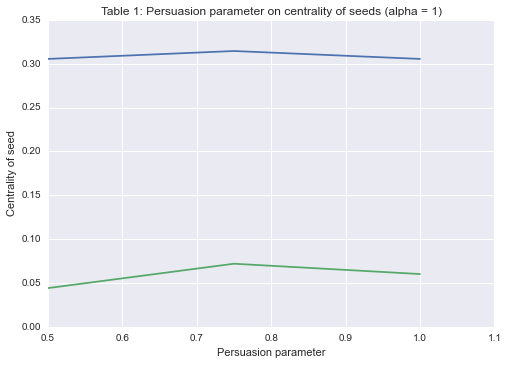

In [25]:
# Create figure

f = plt.plot(output.loc[output.loc[:,"alpha"]==1,"persuasion"], output.loc[output.loc[:,"alpha"]==1,"centrality 1"])
_ = plt.title("Table 1: Persuasion parameter on centrality of seeds (alpha = 1)")
_ = plt.xlabel("Persuasion parameter")
_ = plt.ylabel("Centrality of seed")


f = plt.plot(output.loc[output.loc[:,"alpha"]==1,"persuasion"], output.loc[output.loc[:,"alpha"]==1,"centrality 2"])
_ = plt.title("Table 1: Persuasion parameter on centrality of seeds (alpha = 1)")
_ = plt.xlabel("Persuasion parameter")
_ = plt.ylabel("Centrality of seed")

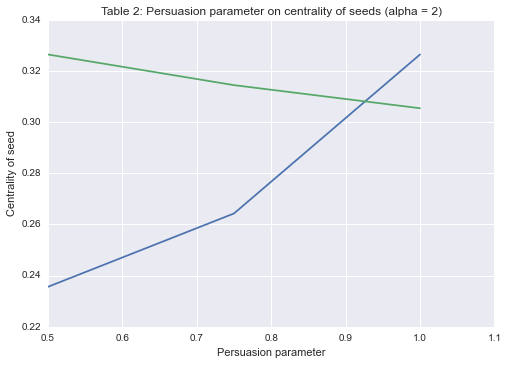

In [26]:
# Create figure

f = plt.plot(output.loc[output.loc[:,"alpha"]==2,"persuasion"], output.loc[output.loc[:,"alpha"]==2,"centrality 1"])
_ = plt.title("Table 2: Persuasion parameter on centrality of seeds (alpha = 2)")
_ = plt.xlabel("Persuasion parameter")
_ = plt.ylabel("Centrality of seed")


f = plt.plot(output.loc[output.loc[:,"alpha"]==2,"persuasion"], output.loc[output.loc[:,"alpha"]==2,"centrality 2"])
_ = plt.title("Table 2: Persuasion parameter on centrality of seeds (alpha = 2)")
_ = plt.xlabel("Persuasion parameter")
_ = plt.ylabel("Centrality of seed")

#### Does persuasion affect centrality?

We also see that when $\alpha=1$, one seed in the optimal pair has high centrality while the other doesn't.  This effect doesn't change with persuasion.  When $\alpha=2$, both optimal seeds have high centrality (note range in y-axis of table 2).  In both cases, the effect does not seem to be mitigated very much through the persuasion paramter.

### Conclusion

To better inform the rollout of an agricultural extension program, Beaman et al collected social network data from villages in Malawi and devised a network-theory based method of selecting optimal 'seed farmers'.  I recreated and expanded upon the modeling in this method to understand whether their optimal seed selection process is sensitive to the path depedence found in other types of information diffusion.  I implemented this path dependence through a stochastic persuasion parameter.  This was a probability governing whether or not a household would adopt the technology after an adequate number of connected households had already adopted the technology. 

I took the network graph of a comparable, rural South Indian village and ran models of information diffusion, varying my persuasion parameter as well as the alpha parameter, which captured the dynamics of simple and complex contagion models.

I found that the persuasion parameter does change the choice of optimal seeds somewhat but there are still a few households (identified as having high eigenvector centrality) that are robust to the persuasion parameter and are found to be optimal across my sweep.  Additionally, easier persuasion has the implied positive effect on percent adoption when $\alpha=1$ but easy persuasion does not matter as much when $\alpha=2$.  A relationship found between the centralities of the two households in an optimal pair was found to be unaffected by the persuasion parameter.

This all suggests that the persuasion parameter only has a small effect on Beaman et al's optimal seed selection method.  Path dependence, at least as defined by my persuasion parameter, is only minimally important when selecting optimal seeds for this type of information diffusion process.  So despite working from a simpler model and not accounting for idiosyncratic non-adoption, the method from Beaman et al identifies many of the same optimal seeds and is largely robust to my persuasion parameter.